In [1]:
library(tidyverse)
library(tidymodels)
library(dplyr)
library(repr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
url <- "https://raw.githubusercontent.com/dzhen2023/dsci-100-2024w1-group-009-12/refs/heads/main/players.csv"
download.file(url, "players.csv") 

player_data <- read_csv("players.csv") 


player_data <- player_data |>
select(experience, played_hours, name)

experience_filtered <- player_data |>
    mutate(experience_scaled = case_when(
        experience == "Veteran" ~ 5,
        experience == "Pro" ~ 4,
        experience == "Regular" ~ 3,
        experience == "Amateur" ~ 2,
        experience == "Beginner" ~ 1,
        TRUE ~ NA_real_)) |> 
    filter(played_hours != "0") |>
    select(experience_scaled, everything())


set.seed(411) 

player_split <- initial_split(experience_filtered, prop = 0.75)
player_training <- training(player_split)
player_testing <- testing(player_split)



head(player_training, n = 10)

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience_scaled,experience,played_hours,name
<dbl>,<chr>,<dbl>,<chr>
2,Amateur,2.1,Sebastián
3,Regular,0.3,Andy
2,Amateur,0.2,Thatcher
5,Veteran,0.1,Bianca
1,Beginner,0.1,Jonas
1,Beginner,0.4,Omkar
1,Beginner,23.7,Isla
3,Regular,223.1,Hiroshi
5,Veteran,0.4,Zoe


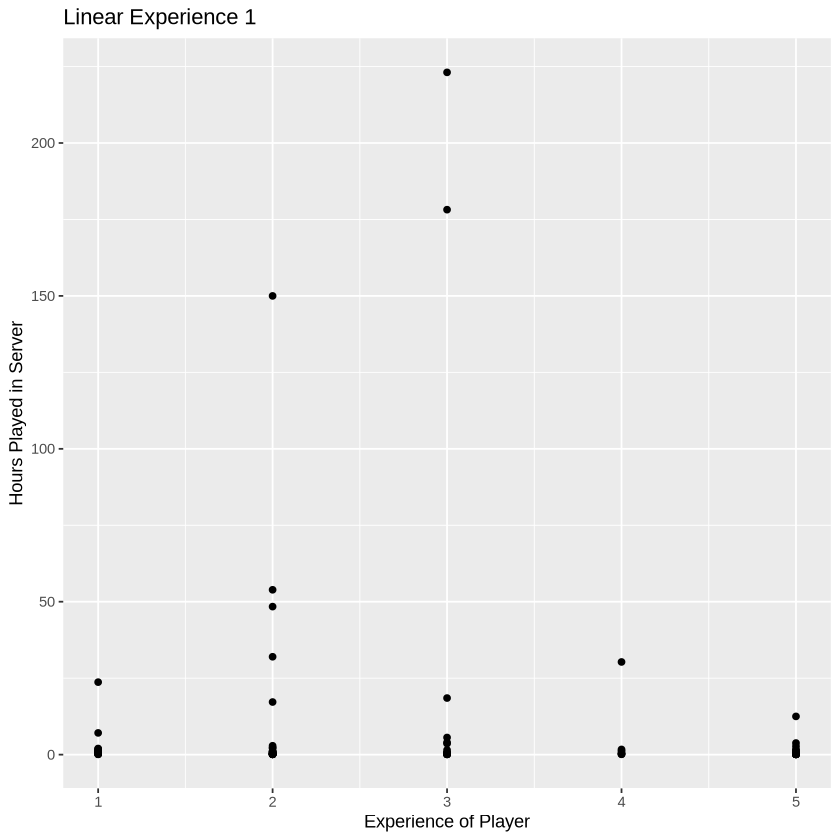

In [3]:
set.seed(411)

plotting <- ggplot(player_training, aes(x = experience_scaled, y = played_hours)) +
    geom_point() +
    labs(x = "Experience of Player", y = "Hours Played in Server", title = "Linear Experience 1")

plotting 

In [4]:
set.seed(411)

lm_spec <- linear_reg() |>
    set_engine("lm") |>
    set_mode("regression")

lm_recipe <- recipe(played_hours ~ experience_scaled, data = player_training)

lm_fit <- workflow() |>
    add_recipe(lm_recipe) |>
    add_model(lm_spec) |>
    fit(data = player_training)

lm_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
      (Intercept)  experience_scaled  
           14.440             -1.421  


In [5]:
set.seed(411)

training_preds <- lm_fit |>
    predict(player_training) |>
    bind_cols(player_training)

head(training_preds, n=10)

.pred,experience_scaled,experience,played_hours,name
<dbl>,<dbl>,<chr>,<dbl>,<chr>
11.596776,2,Amateur,2.1,Sebastián
10.175297,3,Regular,0.3,Andy
11.596776,2,Amateur,0.2,Thatcher
7.332339,5,Veteran,0.1,Bianca
13.018255,1,Beginner,0.1,Jonas
13.018255,1,Beginner,0.4,Omkar
13.018255,1,Beginner,23.7,Isla
10.175297,3,Regular,223.1,Hiroshi
7.332339,5,Veteran,0.4,Zoe


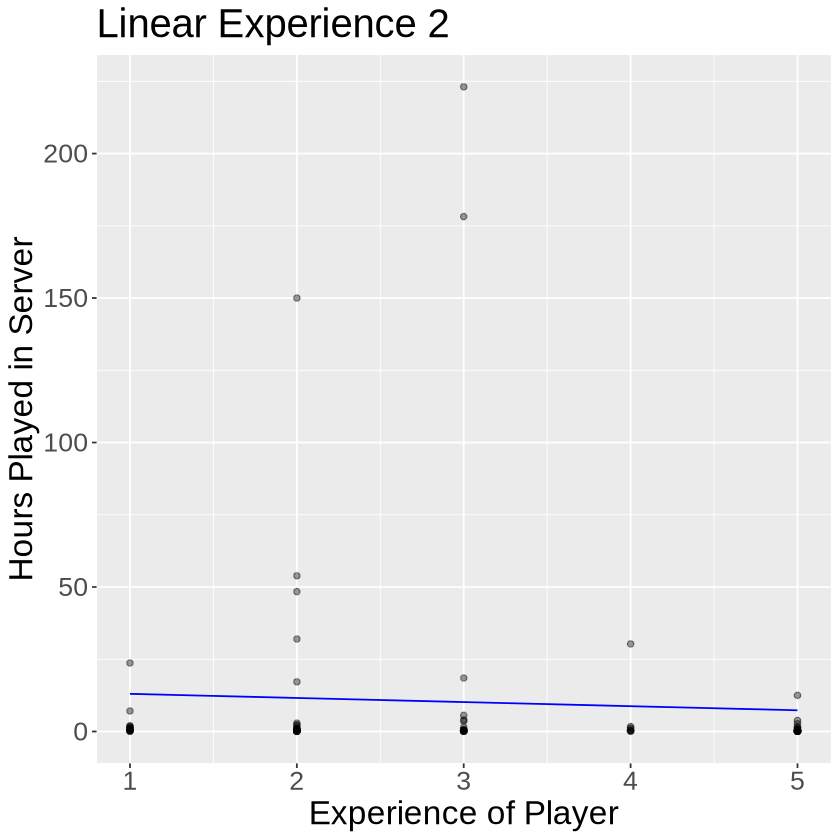

In [6]:
set.seed(411)

lm_predictions <- training_preds |>
    ggplot(aes(x = experience_scaled, y = played_hours)) +
        geom_point(alpha = 0.4) +
        geom_line(
            mapping = aes(x = experience_scaled, y = .pred), 
            color = "blue") +
        xlab("Experience of Player") +
        ylab("Hours Played in Server") +
    labs(title = "Linear Experience 2") +
        theme(text = element_text(size = 20))
lm_predictions

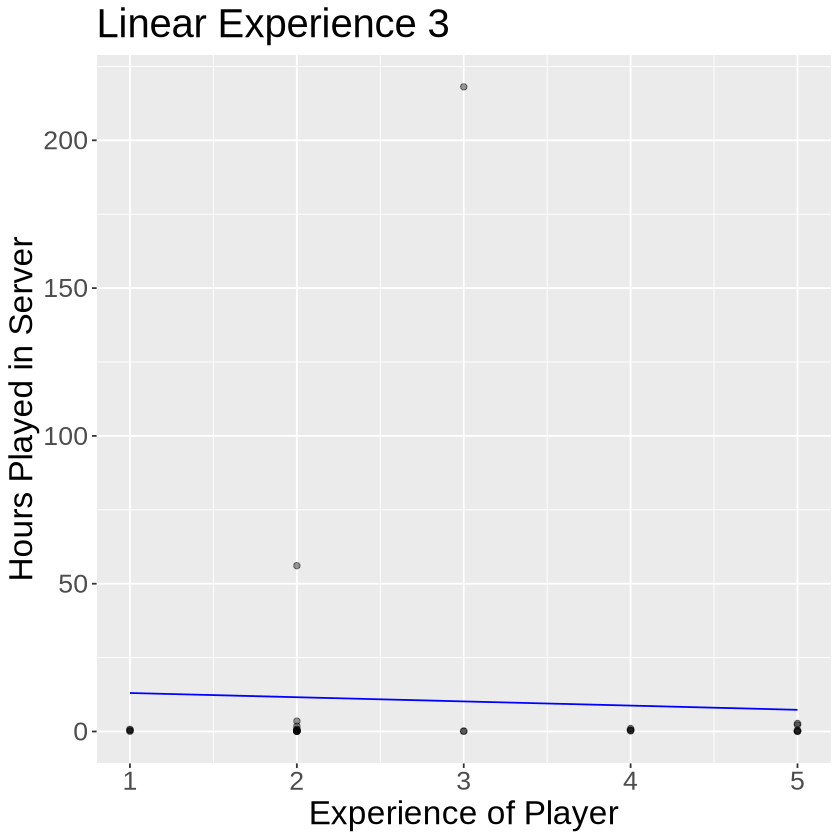

In [7]:
set.seed(411)

testing_pred <- lm_fit |>
    predict(player_testing) |>
    bind_cols(player_testing)

experience_results <- testing_pred |>
    metrics(truth = played_hours, estimate = .pred)
# experience_results

testing_predictions <- testing_pred |>
     ggplot(aes(x = experience_scaled, y = played_hours)) +
        geom_point(alpha = 0.4) +
         geom_line(data = testing_pred,
             mapping = aes(x = experience_scaled, y = .pred), 
            color = "blue") +
         xlab("Experience of Player") +
         ylab("Hours Played in Server") +
    labs(title = "Linear Experience 3") +
         theme(text = element_text(size = 20))

testing_predictions

In [8]:
set.seed(411)

testing_results <- lm_fit |>
    predict(player_testing) |>
    bind_cols(player_testing) |>
    metrics(truth = played_hours, estimate = .pred) 

testing_results

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,4.130139e+01
rsq,standard,1.921336e-04
mae,standard,1.795459e+01
